## e-Commerce A/B 


## Table of Contents
- [Introduction](#intro)
- [Part I - Assess and Clean](#Assess_and_clean)
- [Part II - A/B Test - Sampling Distribution](#ab_test)
- [Part III - A/B Test - Logistic Regression](#regression)


<a id='intro'></a>
### Introduction

We have a dataset containing results from an a/b test peformed by an e-commerce company. The test evaluates performance of a new landing page, with a 'treatment' group landing on the new page, and a 'control' group landing on the old page. The metric of interest in the conversion rate.  

We'll first assess and clean the dataset, make some preliminary observations about each test group, and then perform hypothesis testing via distribution simluations and regression models.

<a id='probability'></a>
### Part I - Assess and Clean

In [2]:
#importing libraries and setting seed
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

In [3]:
#reading in dataset and viewing first rows
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [4]:
#Shape of the dataframe - rows x columns
df.shape

(294478, 5)

In [5]:
#The number of unique user id's in column 'user_id'
df['user_id'].nunique()

290584

The proportion of users converted i.e. conversion rate:

In [6]:
#The mean of column 'converted'
df['converted'].mean()

0.11965919355605512

The number of times the `group` and `landing_page` don't line up:

In [7]:
#Query that returns rows where group value is not associated with correct landing page
mismatch = df.query("group == 'treatment' and landing_page != 'new_page' or group == 'control' and landing_page != 'old_page'")

In [8]:
#Shape of resulting dataframe
mismatch.shape

(3893, 5)

Do any of the rows have missing values?

In [9]:
#Count of NaN values for each column
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

We have 3893 rows with incorrect group and landing page association. As we cannot be certain of whether these users received the correct landing page, we'll create a new dataframe that excludes these rows:

In [10]:
#Dataframe containing only those rows where group and landing page are correctly associated
df2 = df.query("group == 'treatment' and landing_page == 'new_page' or group == 'control' and landing_page == 'old_page'")

In [11]:
# Double Check all of the correct rows were removed
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

How many unique user_ids in df2?

In [12]:
df2['user_id'].nunique()

290584

Any duplicates user_ids in df2?

In [13]:
#Returns any duplicated rows based on values contained in column 'user_id'
df2[df2['user_id'].duplicated() == True]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


We'll remove the duplicate from df2:

In [14]:
#Drops duplicates based on values in column 'user_id'
df2.drop_duplicates(subset = 'user_id', inplace = True)

C:\Users\John\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [15]:
df2[df2['user_id'].duplicated() == True]

,user_id,timestamp,group,landing_page,converted


Overall conversion rate, regardless of group:

In [16]:
#Count of values in column 'converted', normalized to represent proportion
df2['converted'].value_counts(normalize=True)

0    0.880403
1    0.119597
Name: converted, dtype: float64

Conversion rate of control group:

In [17]:
#Mean of column 'converted' for control group only
df2.query("group == 'control'")['converted'].mean()

0.1203863045004612

Conversion rate of treatment group:

In [18]:
#Mean of column 'converted' for treatment group only
df2.query("group == 'treatment'")['converted'].mean()

0.11880806551510564

Proportion of new_page vs old_page

In [19]:
#Count of values in column 'landing_page', normalized to represent proportion
df2['landing_page'].value_counts(normalize = True)

new_page    0.500062
old_page    0.499938
Name: landing_page, dtype: float64

Based on observations so far, the new treatment page leads to less conversions.

<a id='ab_test'></a>
### Part II - A/B Test - Sampling Distribution

We'll now perform hypothesis testing using a sample distribution. We'll structure our hypothesis this way:

Null: The new page converted rate is less than or equal to that of the old page  
Alternative: The new page conversion rate is greater than that of the old page

We'll use numpy's binomial function to simulate test results for each test group under the null, using the global conversion rate of .1196.

We will then create a sampling distribution, by running these same simulations and calculating the difference in simulated conversion rate 10,000 times. We can then calculate the proportion of simulated differences that are greater than our sample statistic, to find our p-value.

Our max error rate will be 5%.


Conversion rate under the null:

In [20]:
df['converted'].value_counts(normalize = True)

0    0.880341
1    0.119659
Name: converted, dtype: float64

How many rows in treatment group?

In [21]:
#The number of rows in treatment group
n_new = df2.query("group == 'treatment'")['user_id'].count()

How many rows in control group?

In [22]:
#The number of rows in control group
n_old = df2.query("group == 'control'")['user_id'].count()

Simulated test results for treatment group:

In [23]:
#simulates transactions using binomial distribution - stores results in variable 'new_page_converted'
new_page_converted = []
for _ in range(n_new):
    result = np.random.binomial(1, 0.1196)
    new_page_converted.append(result)

In [24]:
#Converts to numpy array and calculates mean
new_page_converted = np.array(new_page_converted).mean()

In [25]:
new_page_converted

0.1179271901452068

Simulated results for control group:

In [26]:
#simulates transactions using binomial distribution - stores results in variable 'old_page_converted'
old_page_converted = []
for _ in range(n_old):
    result = np.random.binomial(1, 0.1196)
    old_page_converted.append(result)

In [27]:
#Converts to numpy array and calculates mean
old_page_converted = np.array(old_page_converted).mean()

In [28]:
old_page_converted

0.1181009678263144

Difference in these simulated conversion rates:

In [29]:
#calculates difference in conversion rates
new_page_converted - old_page_converted

-0.00017377768110760083

We'll now run this simulation and calculate the conversion rate difference 10,000 times:

In [30]:
#Simulates 10,000 conversion rate differences based on previous distribution simulations
#stores results in variable 'p_diffs'
new_converted_simulation = np.random.binomial(n_new, 0.1196, 10000)/n_new
old_converted_simulation = np.random.binomial(n_old, 0.1196, 10000)/n_old
p_diffs = new_converted_simulation - old_converted_simulation    

In [31]:
#Converts to numpy array
p_diffs = np.array(p_diffs)

We'll observe our distribution:

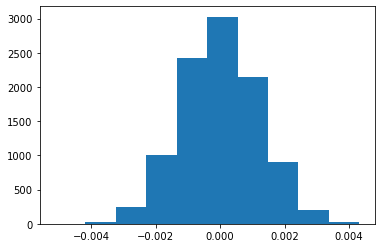

In [32]:
plt.hist(p_diffs);

Now we'll calculate p-value by finding the proportion of simulated conversion rate differences that are larger than our actual observed statistic:

In [33]:
#Calculates difference in conversion rates based on actual data
actual_diff = df2.query("group == 'treatment'")['converted'].mean() - df2.query("group == 'control'")['converted'].mean()

In [34]:
actual_diff

-0.0015782389853555567

In [35]:
#Calculates proportion of values within variable 'p_diffs' that are greater than value of variable 'actual_diff'
(p_diffs > actual_diff).mean()

0.9077

In this case, as the p-value is so large, there is no evidence in support of rejecting the null, or, there is evidence that the new page conversion rate is less than that of the old page.

l. We'll now use a built-in to achieve similar results:

In [36]:
#creates variables for use in z-test
import statsmodels.api as sm

convert_old = df2.query("group == 'control'")
convert_old = convert_old[convert_old['converted'] == 1].shape[0]
convert_new = df2.query("group == 'treatment'")
convert_new = convert_new[convert_new['converted'] == 1].shape[0]
n_old = df2.query("group == 'control'").shape[0]
n_new = df2.query("group == 'treatment'").shape[0]

In [37]:
#Performs the z-test
from statsmodels.stats.proportion import proportions_ztest

ztest, pval = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], value=None, alternative='larger')

In [38]:
#Returns z-score and p-value
ztest, pval

(-1.3109241984234394, 0.9050583127590245)

The z-score shows that the observed statistic is 1.31 standard deviations smaller than the mean, and the p-value shows that we should not reject the null. These both agree with findings above, and they indicate that the new page conversion rate is less than that of the old page.

<a id='regression'></a>
### Part III - A/B Test - Logistic Regression

We'll now create logistic regression models to try and predict conversion based on landing page. Our null and alternative hypotheses now become equal and not equal, respectively.

First, we'll create an intercept and dummy variables:

In [39]:
#Creates an intercept for use in regressions models
df2['intercept'] = 1

C:\Users\John\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [40]:
#Creates dummy variables from values in column 'landing_page'
df2[['ab_page', 'drop']] = pd.get_dummies(df2['landing_page'])

C:\Users\John\anaconda3\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [41]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,drop
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1


We'll create and fit our model:

In [42]:
#Creates and fits logistic regression model
logit_mod = sm.Logit(df2['converted'], df2[['intercept','ab_page']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


And the results:

In [43]:
#returns results of regression test
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2020-10-23 12:54 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

The p-value associated with ab_page is 0.1899. This does not offer any evidence in support of rejecting our null hypothesis

We'll now merge in a dataset containing country data for each user, to see if country might help us predict conversion

In [44]:
df_countries = pd.read_csv('countries.csv')

In [45]:
#Merges dataframes using values in column 'user_id' as join key
df_merged = pd.merge(df2, df_countries, how='inner', left_on=['user_id'], right_on = ['user_id'])

In [46]:
#Creates dummy variables from values in column 'country'
df_merged[['CA', 'UK', 'US']] = pd.get_dummies(df_merged['country'])

In [47]:
df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,drop,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,US,0,0,1


In [48]:
#Creates, fits and returns results of logistic regression model
logit_mod = sm.Logit(df_merged['converted'], df_merged[['intercept', 'UK', 'US']])
results = logit_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.8333
Date:               2020-10-23 12:54 BIC:              212812.5723
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           2                LL-Null:          -1.0639e+05
Df Residuals:       290581           LLR p-value:      0.19835    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0375    0.0260  -78.3639  0.0000  -2.0885  -1.9866
UK             0.0507    0.0284    1.7863  0.0740  -0.0049   0.1064
US             0.0408    0.0269    1.5178  0.1291  -0.0119   0.0935
==================================================================

"""

It appears that country has no impact on conversion. P-values here are both greater than the error rate of 5% 

We'll now use higher order terms to create interactions between landing page and country, to see if these interactions have any relationship to conversion:

In [49]:
df_merged['UK_page'] = df_merged['UK'] * df_merged['ab_page']
df_merged['US_page'] = df_merged['US'] * df_merged['ab_page']
logit_mod = sm.Logit(df_merged['converted'], df_merged[['intercept','ab_page', 'UK', 'US', 'UK_page', 'US_page']])
results = logit_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2020-10-23 12:54 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
ab_page       -0.0674    0.0520   -1.2967  0.1947  -0.1694   0.0345
UK             0.0118    0.0398    0.2957  0.7674  -0.0663   0.0899
US             0.0175    0.0377    0.4652  0.6418  -0.0563   0.0914
UK_page        0.0783    0.0568    1.3783  0.1681  -0.0330   0.1896
US_page        0.0469    0.0538    0.8718  0.3833  -0.0585   0.1523
==================================================================

"""

After adding country/page interaction variables using higher order terms, we still see no evidence in support of rejecting the null hypothesis. The interactions between page and country have no significant effect on conversion. All p-values remain larger than the 5% error rate.

<a id='conclusions'></a>
## Conclusions

Based on the distribution simulations and logistic regressions performed, I conclude that the old page is the better choice, as p-values are all above the error rate of 5%, meaning that we fail to reject the null hypothesis.